# Advanced geometry using the Union components
The Union components allow the user to construct advanced geometry from simple shapes. Each available shape has their own component, here are the currently available geometry components.
- Union_box
- Union_sphere
- Union_cylinder
- Union_cone

They differ in their parameters describing the geometry, but are otherwise identical. In this notebook we will show how to construct hollow geometries with several layers, and that multiple scattering between these quickly result in complex behavior.

In [1]:
from mcstasscript.interface import instr, functions, plotter

In [2]:
instrument = instr.McStas_instr("python_tutorial", input_path="run_folder")

### Setting up some standard materials
Before setting up the geometry, we need some material definition, here we set up aluminium and a sample powder.

In [3]:
Al_inc = instrument.add_component("Al_inc", "Incoherent_process")
Al_inc.sigma = 4*0.0082 # 4 atoms per unit cell
Al_inc.unit_cell_volume = 66.4

Al_pow = instrument.add_component("Al_pow", "Powder_process")
Al_pow.reflections = '"Al.laz"'

Al = instrument.add_component("Al", "Union_make_material")
Al.process_string = '"Al_inc,Al_pow"'
Al.my_absorption = 100*4*0.231/66.4 # barns [m^2 E-28]*Å^3 [m^3 E-30]=[m E-2]

Sample_inc = instrument.add_component("Sample_inc", "Incoherent_process")
Sample_inc.sigma = 4*3.4176
Sample_inc.unit_cell_volume = 1079.1

Sample_pow = instrument.add_component("Sample_pow", "Powder_process")
Sample_pow.reflections = '"Na2Ca3Al2F14.laz"'

Sample = instrument.add_component("Sample", "Union_make_material")
Sample.process_string = '"Sample_inc,Sample_pow"'
Sample.my_absorption = 100*4*2.9464/1079.1

### Set up source
We will also need a source, and allow the wavelength to be tuned with a instrument parameter.

In [4]:
src = instrument.add_component("source", "Source_div")

src.xwidth = 0.01
src.yheight = 0.035
src.focus_aw = 0.01
src.focus_ah = 0.01
src.lambda0 = instrument.add_parameter("wavelength", value=5.0,
                                       comment="Wavelength in [Ang]")
src.dlambda = "0.01*wavelength"
src.flux = 1E13

## Describing the geometry of a simple cryostat
A cryostat is a complex geometry with several layers to consider. The way geometry is described in the Union components aims to make it easy to describe such systems. This is aciheved by allowing the simple geometries to overlap, and having a value called the priority to determine which is active in a given volume. If two geometries overlap, the overlapping region gets the physics from the geometry with the highest priority. In that way a cryostat model can be created by having a high priority for the sample in the center, and decreasing the priority as we move out.

The ray tracing algorithm can however not handle if two geometries overlap perfectly, even with a single side. This could be two boxes sharing a side.

Let us look at the parameters for a Union geometry component.

In [5]:
instrument.component_help("Union_cylinder")

 ___ Help Union_cylinder ____________________________________________________________
|optional parameter|required parameter|default value|user specified value|
material_string = 0 [] // material name of this volume, defined using 
                          Union_make_material 
priority [1] // priotiry of the volume (can not be the same as another volume) 
                A high priority is on top of low. 
radius [m] // Outer radius volume in (x,z) plane
yheight [m] // Cylinder height in (y) direction
visualize = 1.0 [1] // set to 0 if you wish to hide this geometry in mcdisplay
target_index = 0 [1] // Relative index of component to focus at, e.g. next is +1
target_x = 0.0 [m]
target_y = 0.0 [m] // Position of target to focus at
target_z = 0.0 [m]
focus_aw = 0.0 [deg] // horiz. angular dimension of a rectangular area
focus_ah = 0.0 [deg] // vert. angular dimension of a rectangular area
focus_xw = 0.0 [m] // horiz. dimension of a rectangular area
focus_xh = 0.0 [m] // vert. dimension of

The geometry components have many parameters due to their flexibility, but only a few are needed for basic use.
- material_string : string for selecting an available material
- priority : number, in case of overlap the geometry with highest priority decides the material properties
- geometrical parameters : Here radius and yheight

In addition there is a focusing system where scattering of physical processes that support this can be forced to a certain direction, this is controlled with these parameters, but are rarely used:
- target_index : relative component index of target
- target_x : if target_index not set, relative x coordinate of target
- target_y : if target_index not set, relative y coordinate of target
- target_z : if target_index not set, relative z coordinate of target
- focus_aw : angular width of focusing cone (either specify angular, box or circular)
- focus_ah : angular height of focusing cone 
- focus_xw : spatial width of focusing cone (box type focusing)
- focus_xh : spatial height of focusing
- focus_r : spatial radius of focusing cone (circular)

Finally there is p_interact, which is used for controlling Monte Carlo sampling frequency of the geometry, as it controls the probability for scattering occurring for any path before or after scattering.

The remaining parameters including masks and number_of_activations are for advanced rules which will be described in a later tutorial.

### First geometry, a sample in a container

We have defined the following materials that are available to us:
- Al
- Sample

Lets start by building a simple powder container with a lid.

In [6]:
sample_geometry = instrument.add_component("sample_geometry", "Union_cylinder")
sample_geometry.yheight = 0.03
sample_geometry.radius = 0.0075
sample_geometry.material_string='"Sample"' 
sample_geometry.priority = 100
sample_geometry.set_AT([0,0,1], RELATIVE=src)

container = instrument.add_component("sample_container", "Union_cylinder")
container.set_RELATIVE(sample_geometry)
container.yheight = 0.03+0.003 # 1.5 mm top and button
container.radius = 0.0075 + 0.0015 # 1.5 mm sides of container
container.material_string='"Al"' 
container.priority = 99

container_lid = instrument.add_component("sample_container_lid", "Union_cylinder")
container_lid.set_AT([0, 0.0155, 0], RELATIVE=container)
container_lid.yheight = 0.004
container_lid.radius = 0.013
container_lid.material_string='"Al"' 
container_lid.priority = 98

### Set up loggers to check what is going on
In order to view what geometry we have set up, we set up three loggers that view the scattering projected onto three different planes. These record the spatail distribution of scattering events.

In [7]:
logger_zx = instrument.add_component("logger_space_zx", "Union_logger_2D_space")
logger_zx.set_RELATIVE(sample_geometry)
logger_zx.D_direction_1 = '"z"'
logger_zx.D1_min = -0.02
logger_zx.D1_max = 0.02
logger_zx.n1 = 300
logger_zx.D_direction_2 = '"x"'
logger_zx.D2_min = -0.02
logger_zx.D2_max = 0.02
logger_zx.n2 = 300
logger_zx.filename = '"logger_zx.dat"'

logger_zy = instrument.add_component("logger_space_zy", "Union_logger_2D_space")
logger_zy.set_RELATIVE(sample_geometry)
logger_zy.D_direction_1 = '"z"'
logger_zy.D1_min = -0.02
logger_zy.D1_max = 0.02
logger_zy.n1 = 300
logger_zy.D_direction_2 = '"y"'
logger_zy.D2_min = -0.02
logger_zy.D2_max = 0.02
logger_zy.n2 = 300
logger_zy.filename = '"logger_zy.dat"'

logger_xy = instrument.add_component("logger_space_xy", "Union_logger_2D_space")
logger_xy.set_RELATIVE(sample_geometry)
logger_xy.D_direction_1 = '"x"'
logger_xy.D1_min = -0.02
logger_xy.D1_max = 0.02
logger_xy.n1 = 300
logger_xy.D_direction_2 = '"y"'
logger_xy.D2_min = -0.02
logger_xy.D2_max = 0.02
logger_xy.n2 = 300
logger_xy.filename = '"logger_xy.dat"'

### Add master component
We need to remember to add a master component to actually perform the simulation.

In [8]:
master = instrument.add_component("master", "Union_master")

### Add banana monitor
We are also interested in viewing some scattering data, here we add a banana monitor using the Monitor_nD component.

In [9]:
banana = instrument.add_component("banana", "Monitor_nD", RELATIVE=sample_geometry)
banana.xwidth = 1.5
banana.yheight = 0.4
banana.restore_neutron = 1
banana.options = '"theta limits=[5 175] bins=250, banana"'

## Run simulation
Now we need to run the simulation to view the geometry we have built.

In [10]:
instrument.set_parameters(wavelength=3.0)
instrument.settings(ncount=3E6, output_path="data_folder/union_geometry")
instrument.show_settings()

data = instrument.backengine()

Instrument settings:
  ncount:           3.00e+06
  output_path:      data_folder/union_geometry
  run_path:         run_folder
  package_path:     /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1
  executable_path:  /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1/bin/
  executable:       mcrun
  force_compile:    True
INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_geometry_49"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, c

### Plotting the data
Due to the large differences between the scattered intensity from parts in the direct beam and outside, we use a logarithmic axis to display scattered intensity. We limit it to 4 orders of magnitude below the maximum intensity, otherwise a single very low intensity event can draw the intensity axis out to a large interval making it difficult to see the important nuances.

Plotting data with name logger_space_zx
Plotting data with name logger_space_zy
Plotting data with name logger_space_xy
Plotting data with name banana


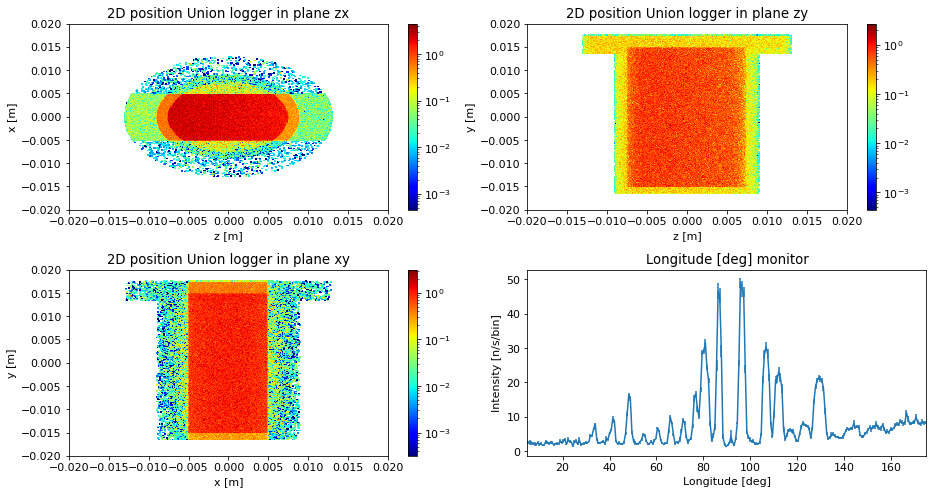

In [11]:
functions.name_plot_options("logger_space_zx", data, log=True, orders_of_mag=4)
functions.name_plot_options("logger_space_zy", data, log=True, orders_of_mag=4)
functions.name_plot_options("logger_space_xy", data, log=True, orders_of_mag=4)
plotter.make_sub_plot(data)

### Interpretation of results
The beam is narrower than the sample, but taller than the can, so some parts of the sample powder are not directly illuminated, and can thus be seen as a intensity area especially on the zx logger image. The aluminum scatters less, and so lower intensity still.

## Adding a cryostat around the sample can
We can add a crude model of a cryostat around our sample can by adding more Union geometry components. They have to be before the Union_master in the McStas instrument file, so we use the keyword argument *before* in the *add_component* method to specify this when adding the components.

We also need to designate areas as empty, this is done using the default material Vacuum which has no absorption or scattering processes. In this way we can create several layers by decreasing the priority when going out.

In [12]:
inner_wall = instrument.add_component("cryostat_wall", "Union_cylinder",
                                      before="master")
inner_wall.set_AT([0,0,0], RELATIVE=sample_geometry)
inner_wall.yheight = 0.12
inner_wall.radius = 0.03
inner_wall.material_string='"Al"' 
inner_wall.priority = 80

inner_wall_vac = instrument.add_component("cryostat_wall_vacuum", "Union_cylinder",
                                          before="master")
inner_wall_vac.set_AT([0,0,0], RELATIVE=sample_geometry)
inner_wall_vac.yheight = 0.12 - 0.008
inner_wall_vac.radius = 0.03 - 0.002
inner_wall_vac.material_string='"Vacuum"' 
inner_wall_vac.priority = 81

outer_wall = instrument.add_component("outer_cryostat_wall", "Union_cylinder",
                                      before="master")
outer_wall.set_AT([0,0,0], RELATIVE=sample_geometry)
outer_wall.yheight = 0.15
outer_wall.radius = 0.1
outer_wall.material_string='"Al"' 
outer_wall.priority = 60

outer_wall_vac = instrument.add_component("outer_cryostat_wall_vacuum", "Union_cylinder",
                                          before="master")
outer_wall_vac.set_AT([0,0,0], RELATIVE=sample_geometry)
outer_wall_vac.yheight = 0.15 - 0.01
outer_wall_vac.radius = 0.1 - 0.003
outer_wall_vac.material_string='"Vacuum"' 
outer_wall_vac.priority = 61

### Adjusting the logger view to see the larger cryostat area
The loggers were only viewing a small area around the sample can, but this can be expanded as we still have access to the component objects.

In [13]:
logger_zx.set_parameters(D1_min=-0.12, D1_max=0.12, D2_min=-0.12, D2_max=0.12)
logger_zy.set_parameters(D1_min=-0.12, D1_max=0.12, D2_min=-0.12, D2_max=0.12)
logger_xy.set_parameters(D1_min=-0.12, D1_max=0.12, D2_min=-0.12, D2_max=0.12)

### Viewing the instrument
The instrument can be viewed with the *show_instrument* method. The mock cryostat and detector can be seen in a 3D view.

In [17]:
instrument.show_instrument()

### Run the updated instrument file
Run the simulation with the added cryostat, since no parameters or settings are changed it is enough to just call the backengine function and grab the new data.

In [14]:
data_cryo = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_geometry_50"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                         

### Plot the data from the new simulation
Here we increase the orders of magnitude of intensity plotted on the log plots. Try to play with these values to see how it changes the plots.

Plotting data with name logger_space_zx
Plotting data with name logger_space_zy
Plotting data with name logger_space_xy
Plotting data with name banana


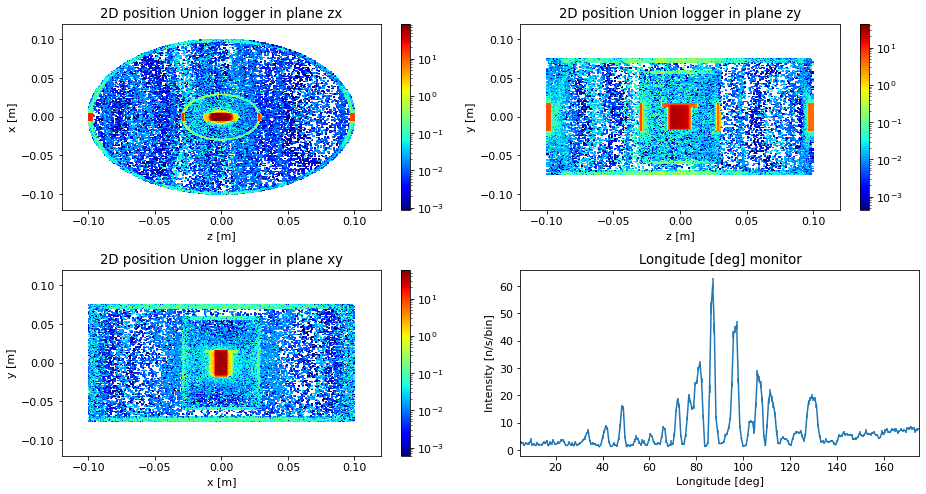

In [15]:
plotter.make_sub_plot(data_cryo, log=[True, True, True, False], orders_of_mag=5)

### Interpreting the data
The different layers of the cryostat both result in scattering from the aluminium the beam has to move through, but also some increase intensity where it illuminated by scattering from the sample.

### Comparing situation with and without cryostat
It could be interesting to see what difference adding the cryostat did to the measured signal in the banana monitor, here we extract the numpy arrays and plot them manually with matplotlib for at direct comparison. Ensure you run the two simulations with the same wavelength in order for a comparison to be meaningful.

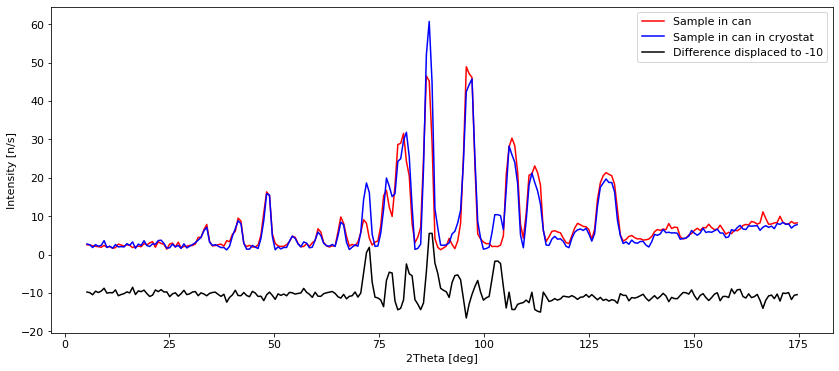

In [16]:
banana_can = functions.name_search("banana", data)
banana_cryo = functions.name_search("banana", data_cryo)

import copy
import numpy as np
banana_diff = copy.deepcopy(banana_cryo)
banana_diff.Intensity = banana_cryo.Intensity - banana_can.Intensity
banana_diff.Error = np.sqrt(banana_cryo.Error**2 + banana_can.Error**2)

import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.plot(banana_can.xaxis, banana_can.Intensity, "r",
         banana_cryo.xaxis, banana_cryo.Intensity, "b",
         banana_diff.xaxis, banana_diff.Intensity-10.0, "k")
plt.xlabel("2Theta [deg]")
plt.ylabel("Intensity [n/s]")
l = plt.legend(["Sample in can", "Sample in can in cryostat", "Difference displaced to -10"])